In [2]:
import sys
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np

try:
    if not(changed):
        raise Exception()
except:
    sys.path.append(str(Path(".").absolute().parent))
    changed = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from notebooks.notebooks_utils import get_activation, load_checkpoint

In [4]:
def plot_representation(model_name, activations, block_name="InteractionBlock", aggregation="mean", ax=None):
    interaction_values = []
    for key, value in activations.items():
        if block_name in key:
            if "Ewald" in block_name:
                value = value[0].cpu().numpy().mean(axis=0)
            else:
                value = value.cpu().numpy().mean(axis=0)
            interaction_values.append(value.reshape(1, -1))
    interaction_values = np.concatenate(interaction_values, axis=0)
    if aggregation == "mean":
        interaction_values = interaction_values.mean(0)
    elif aggregation == "sum":
        interaction_values = interaction_values.sum(0)
    if ax is False:
        return None, interaction_values
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(interaction_values, label=block_name)
    ax.set_xlabel("Hidden channel")
    ax.set_ylabel("Representation")
    ax.set_title(f"{model_name} - Hidden representation for the model with Ewald")
    ax.legend()
    return ax, interaction_values

def plot_activations_ewald(model_name, ewald_activation, base_activation, aggregation="mean"):
    ax, ewald_interaction_values = plot_representation(model_name, ewald_activation, block_name="EwaldBlock", aggregation=aggregation)
    ax, interaction_values = plot_representation(model_name, ewald_activation, block_name="InteractionBlock", aggregation=aggregation, ax=ax)

    _, base_interaction_values = plot_representation(model_name, base_activation, block_name="InteractionBlock", aggregation="mean", ax=False)

    fig, ax3 = plt.subplots()
    ax3.plot(base_interaction_values, label="Base model: Interaction")
    ax3.plot(base_interaction_values + ewald_interaction_values, label="Ewald model: Ewald + Interaction")
    ax3.set_xlabel("Hidden channel")
    ax3.set_ylabel("Representation")
    ax3.set_title(f"{model_name} - Hidden representations for the model with Ewald")
    ax3.legend()
    plt.show()

def get_activations_ewald(ewald_trainer, base_trainer, model_name="FAENet", aggregation="mean"):
    loader = base_trainer.get_dataloader(ewald_trainer.datasets["train"], ewald_trainer.samplers["train"])

    ewald_activation = {}
    base_activation = {}

    try:
        for i, block in enumerate(ewald_trainer.model.module.interaction_blocks):
            block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", ewald_activation))
    except:
        for i, block in enumerate(ewald_trainer.model.module.interactions):
            block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", ewald_activation))
    for i, block in enumerate(ewald_trainer.model.module.ewald_blocks):
        block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", ewald_activation))

    try:
        for i, block in enumerate(base_trainer.model.module.interaction_blocks):
            block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", base_activation))
    except:
        for i, block in enumerate(base_trainer.model.module.interactions):
                block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", base_activation))

    with torch.no_grad():
        x = next(iter(loader))
        ewald_output = ewald_trainer.model_forward(x)
        base_output = base_trainer.model_forward(x)

    plot_activations_ewald(model_name, ewald_activation, base_activation, aggregation=aggregation)

    return ewald_activation, base_activation, x

In [20]:
#Loading models:

# # Using 10k splits
# with tag0
job_id_ewald = "4119576" #faenet
job_id = "4119596" # faenet
ewald_trainer_faenet_with_tag0 = load_checkpoint(job_id_ewald)
base_trainer_faenet_with_tag0 = load_checkpoint(job_id)
loader_faenet_with_tag0 = base_trainer_faenet_with_tag0.get_dataloader(ewald_trainer_faenet_with_tag0.datasets["train"], ewald_trainer_faenet_with_tag0.samplers["train"])

# without tag0
job_id_ewald = "4119577" #faenet
job_id = "4119592" # faenet
# job_id_ewald = "4344309" #faenet
# job_id = "4344494" # faenet
ewald_trainer_faenet_without_tag0 = load_checkpoint(job_id_ewald)
base_trainer_faenet_without_tag0 = load_checkpoint(job_id)
loader_faenet_without_tag0 = base_trainer_faenet_without_tag0.get_dataloader(ewald_trainer_faenet_without_tag0.datasets["train"], ewald_trainer_faenet_without_tag0.samplers["train"])

# with tag0
job_id_ewald = "4119575" # schnet
job_id = "4123618" #schnet

ewald_trainer_schnet_with_tag0 = load_checkpoint(job_id_ewald)
base_trainer_schnet_with_tag0 = load_checkpoint(job_id)
loader_schnet_with_tag0 = base_trainer_schnet_with_tag0.get_dataloader(ewald_trainer_schnet_with_tag0.datasets["train"], ewald_trainer_schnet_with_tag0.samplers["train"])

# remove tag 0
job_id_ewald = "4119572" # schnet
job_id = "4123617" #schnet

ewald_trainer_schnet_without_tag0 = load_checkpoint(job_id_ewald)
base_trainer_schnet_without_tag0 = load_checkpoint(job_id)
loader_schnet_without_tag0 = base_trainer_schnet_without_tag0.get_dataloader(ewald_trainer_schnet_without_tag0.datasets["train"], ewald_trainer_schnet_without_tag0.samplers["train"])

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/a/ali.ramlaoui/ocp/runs/4119576/checkpoints/checkpoint-0043164.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '2D', 'fa_method': 'random', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 5, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_channel

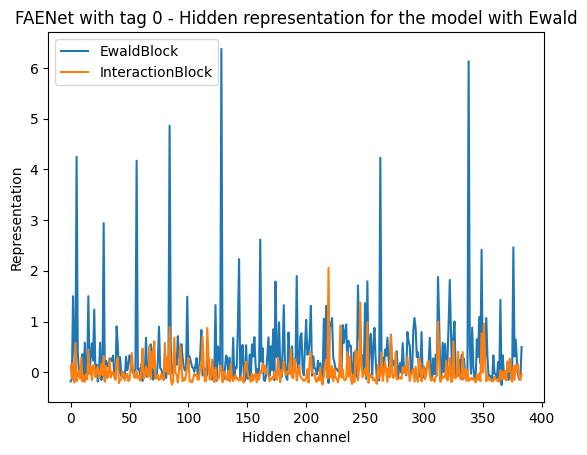

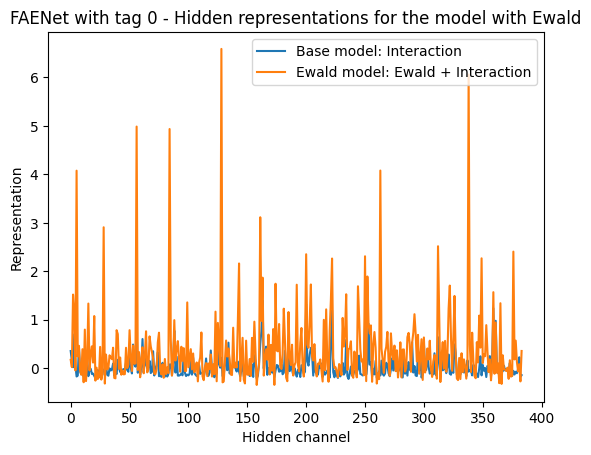

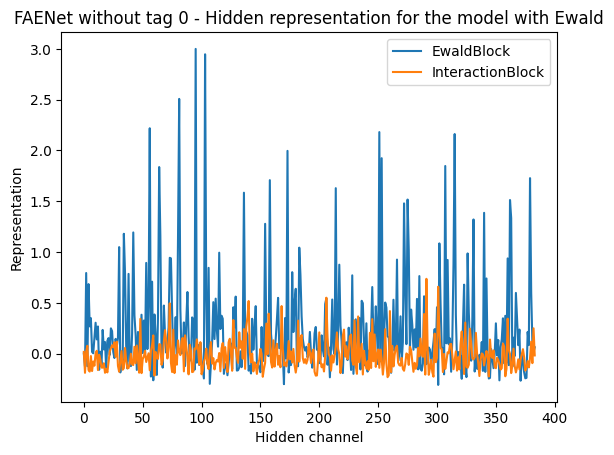

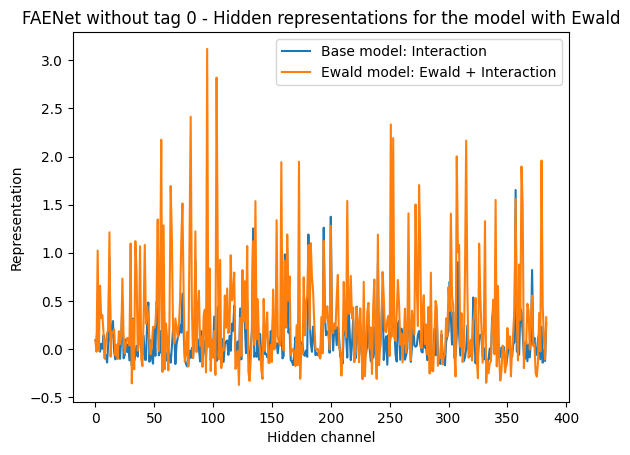

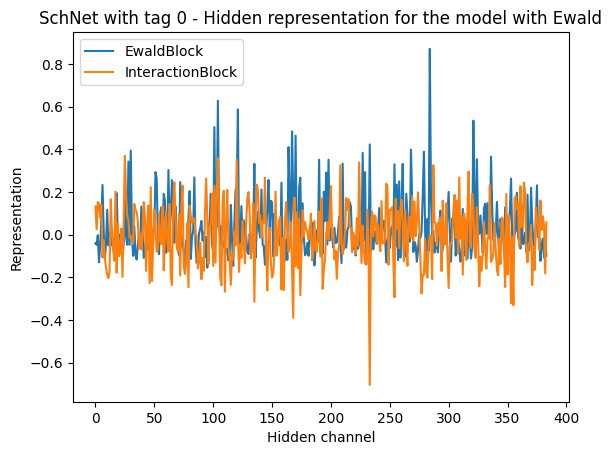

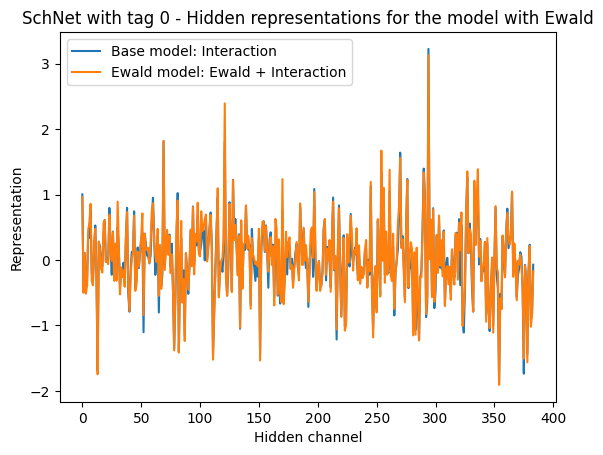

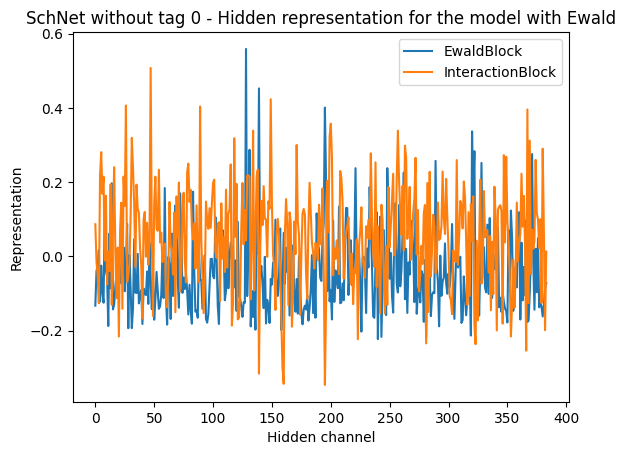

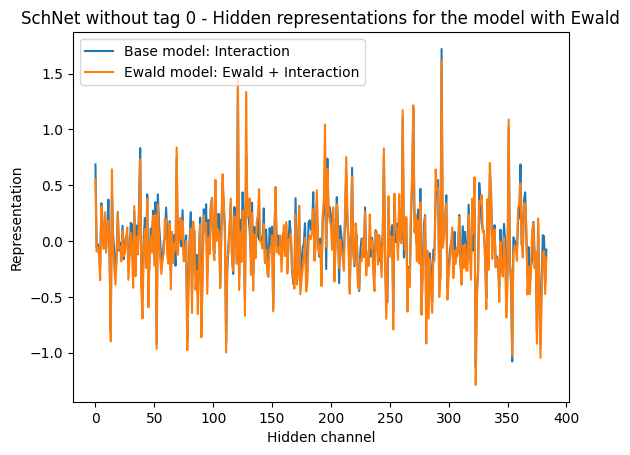

In [21]:
%matplotlib inline
ewald_activation_faenet_with_tag0, base_activation_faenet_with_tag0, x_with_tag0 = get_activations_ewald(ewald_trainer_faenet_with_tag0, base_trainer_faenet_with_tag0, model_name="FAENet with tag 0")
ewald_activation_faenet_without_tag0, base_activation_faenet_without_tag0, x_without_tag0 = get_activations_ewald(ewald_trainer_faenet_without_tag0, base_trainer_faenet_without_tag0, model_name="FAENet without tag 0")

ewald_activation_schnet_with_tag0, base_activation_schnet_with_tag0, _ = get_activations_ewald(ewald_trainer_schnet_with_tag0, base_trainer_schnet_with_tag0, model_name="SchNet with tag 0")
ewald_activation_schnet_without_tag0, base_activation_schnet_without_tag0, _ = get_activations_ewald(ewald_trainer_schnet_without_tag0, base_trainer_schnet_without_tag0, model_name="SchNet without tag 0")

In [7]:
x = next(iter(loader_schnet_with_tag0))
print(x[0].tags)

x = next(iter(loader_schnet_without_tag0))
print(x[0].tags)

tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2])


In [8]:
from notebooks.notebooks_utils import process_datapoint

In [9]:
x = next(iter(loader_schnet_with_tag0))[0]

x, x.tags
#tag 1: Cataclyst surface
#tag 0: Catalyst subsurface
#tag 2: adsorbate

(DataBatch(edge_index=[2, 2985], pos=[65, 3], cell=[1, 3, 3], atomic_numbers=[65], natoms=[1], cell_offsets=[2985, 3], force=[65, 3], distances=[2985], fixed=[65], sid=[1], tags=[65], y_init=[1], y_relaxed=[1], pos_relaxed=[65, 3], id=[1], load_time=[1], transform_time=[1], total_get_time=[1], idx_in_dataset=[1], batch=[65], ptr=[2], neighbors=[1]),
 tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
         0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2]))

In [13]:
trainer = ewald_trainer_faenet_without_tag0
x_processed = process_datapoint(x, trainer)
x_processed

Data(x=[65], edge_index=[2, 2985], edge_attr=[2985, 104], pos=[65, 3], cell=[1, 3, 3], cell_offsets=[2985, 3], neighbors=[1], distance_vec=[2985, 3], energy_skip_co=[0], tags=[65], force=[65, 3])

In [14]:
from torch_geometric.utils import to_networkx
import networkx as nx

def oc20_to_graph(x, processed=True):
    #Undirected graph
    if not processed:
        return to_networkx(x, node_attrs=["pos", "tags", "force"], edge_attrs=["cell_offsets"], to_undirected=True)
    return to_networkx(x, node_attrs=["pos", "tags", "x", "force"], edge_attrs=["distance_vec", "cell_offsets"], to_undirected=True)

data_graph = oc20_to_graph(x_processed)

Graph with 65 nodes and 1411 edges
{0: [-0.6850501894950867, 0.9344816207885742, 13.681706428527832], 1: [7.2906880378723145, 2.66188383102417, 23.953521728515625], 2: [-1.582872986793518, 6.116687774658203, 18.1054630279541], 3: [2.853907585144043, 4.389286041259766, 21.02949333190918], 4: [0.2730425298213959, 3.384279727935791, 19.013519287109375], 5: [8.248780250549316, 5.111681938171387, 18.608671188354492], 6: [4.709823131561279, 1.6568777561187744, 21.937549591064453], 7: [3.812000274658203, 6.839084148406982, 26.36130714416504], 8: [2.2669501304626465, 3.8162858486175537, 16.243274688720703], 9: [-2.169830322265625, 5.54368782043457, 23.99591064453125], 10: [6.703730583190918, 2.088883638381958, 19.16730499267578], 11: [11.140511512756348, 0.36148160696029663, 22.091333389282227], 12: [9.733560562133789, 0.5024756193161011, 18.971132278442383], 13: [5.296780586242676, 2.2298777103424072, 16.047101974487305], 14: [-3.5767805576324463, 5.6846818923950195, 20.875707626342773], 15: 

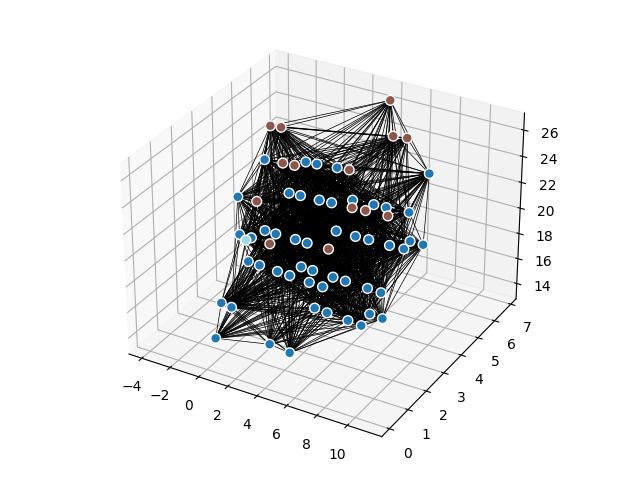

In [15]:
# plot undirected graph
import matplotlib.pyplot as plt
%matplotlib widget

#Extract positions of nodes from node attributes:
def plot_element_3d(data_graph, order=None, clusters=None):
    if order is None:
        order = list(data_graph.nodes())
    if clusters is not None:
        tags = clusters
    else:
        tags = np.array(list(nx.get_node_attributes(data_graph, "tags").values()))
    print(data_graph)
    data_graph = data_graph.subgraph(order)
    pos = nx.get_node_attributes(data_graph, "pos")
    print(pos)
    # use tags for coloring
    node_xyz = np.array([pos[i] for i in range(len(pos))])
    edge_xyz = np.array([[pos[i], pos[j]] for i, j in data_graph.edges()])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(*node_xyz.T, s=50, ec='w', c=tags, cmap='tab20', alpha=1)

    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, c='k', lw=0.5)

    fig.tight_layout()
    plt.show()

plot_element_3d(data_graph)

228it [00:06, 36.10it/s]

Data(x=[65], edge_index=[2, 2985], edge_attr=[2985, 104], pos=[65, 3], cell=[1, 3, 3], cell_offsets=[2985, 3], neighbors=[1], distance_vec=[2985, 3], energy_skip_co=[0], tags=[65], force=[65, 3])
tensor(0)
Graph with 44 nodes and 232 edges
{0: [8.272542953491211, 5.562250137329102, 14.704758644104004], 1: [8.272542953491211, 18.846086502075195, 10.764727592468262], 2: [4.864333152770996, 7.721586227416992, 16.674774169921875], 3: [4.864333152770996, 21.005422592163086, 12.734743118286133], 4: [1.704105019569397, 1.0796680450439453, 18.644790649414062], 5: [1.704105019569397, 14.363504409790039, 14.704758644104004], 6: [11.432770729064941, 12.204168319702148, 12.734743118286133], 7: [11.432770729064941, 25.488004684448242, 8.79471206665039], 8: [11.718972206115723, 7.749975204467773, 14.704758644104004], 9: [11.718972206115723, 21.033811569213867, 10.764727592468262], 10: [1.4179035425186157, 5.5338616371154785, 16.674774169921875], 11: [5.150534629821777, 12.175780296325684, 14.7047586

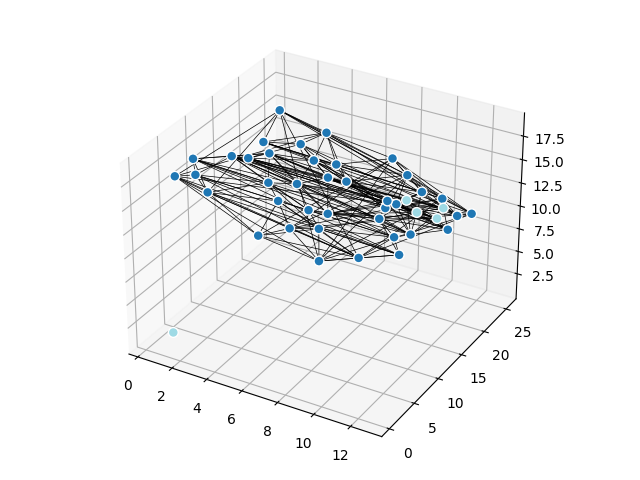

286it [00:08, 35.35it/s]

Data(x=[65], edge_index=[2, 2985], edge_attr=[2985, 104], pos=[65, 3], cell=[1, 3, 3], cell_offsets=[2985, 3], neighbors=[1], distance_vec=[2985, 3], energy_skip_co=[0], tags=[65], force=[65, 3])
tensor(1)
Graph with 23 nodes and 179 edges
{0: [6.461173057556152, 4.126348972320557, 17.96512222290039], 1: [2.990630865097046, 3.801461696624756, 18.904638290405273], 2: [5.294966697692871, 2.048938274383545, 20.084077835083008], 3: [4.315190315246582, 6.110409259796143, 18.595800399780273], 4: [0.8112412691116333, 1.7142943143844604, 18.09724235534668], 5: [7.533168792724609, 5.936805725097656, 19.65876007080078], 6: [6.790035247802734, 8.639100074768066, 19.449792861938477], 7: [2.784688711166382, 8.20429515838623, 19.78475570678711], 8: [13.241095542907715, 4.126348972320557, 18.280715942382812], 9: [9.770553588867188, 3.801461696624756, 19.220230102539062], 10: [12.074889183044434, 2.048938274383545, 20.399669647216797], 11: [11.095112800598145, 6.110409259796143, 18.911394119262695], 1

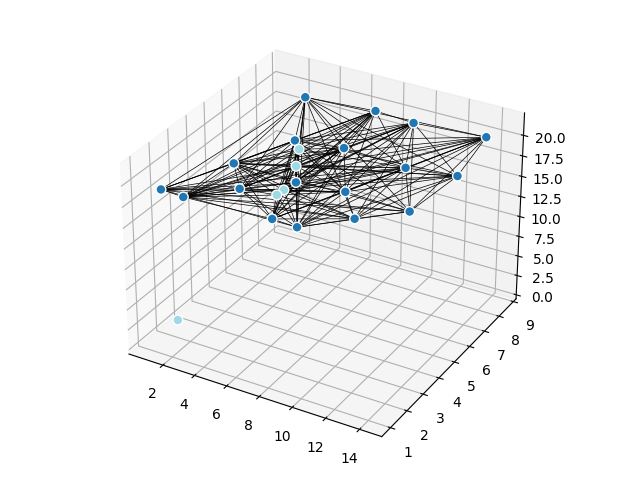

512it [00:16, 34.41it/s]

Data(x=[65], edge_index=[2, 2985], edge_attr=[2985, 104], pos=[65, 3], cell=[1, 3, 3], cell_offsets=[2985, 3], neighbors=[1], distance_vec=[2985, 3], energy_skip_co=[0], tags=[65], force=[65, 3])
tensor(1)
Graph with 27 nodes and 210 edges
{0: [1.4195756912231445, 1.7909842729568481, 19.62464714050293], 1: [4.258727073669434, 12.324040412902832, 17.556596755981445], 2: [1.4195756912231445, 12.324040412902832, 19.62464714050293], 3: [4.258727073669434, 1.7909842729568481, 17.556596755981445], 4: [2.839151382446289, 4.705008506774902, 18.590621948242188], 5: [0.0, 9.410017013549805, 18.590621948242188], 6: [2.839151382446289, 9.410017013549805, 18.590621948242188], 7: [0.0, 4.705008506774902, 18.590621948242188], 8: [7.097878456115723, 1.7909842729568481, 19.62464714050293], 9: [9.937029838562012, 12.324040412902832, 17.556596755981445], 10: [7.097878456115723, 12.324040412902832, 19.62464714050293], 11: [9.937029838562012, 1.7909842729568481, 17.556596755981445], 12: [8.517454147338867,

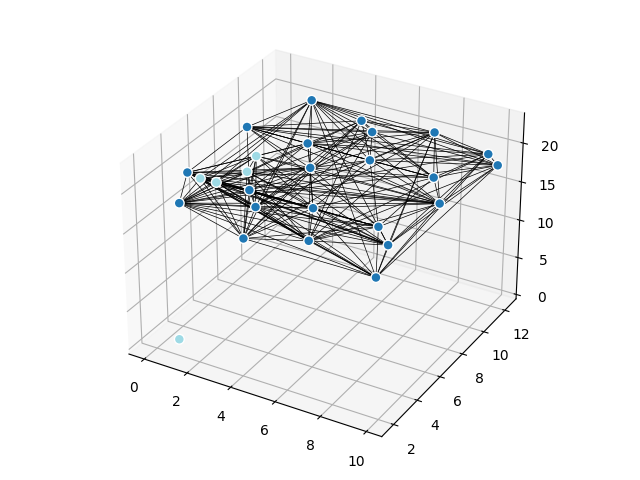

537it [00:17, 28.70it/s]

Data(x=[65], edge_index=[2, 2985], edge_attr=[2985, 104], pos=[65, 3], cell=[1, 3, 3], cell_offsets=[2985, 3], neighbors=[1], distance_vec=[2985, 3], energy_skip_co=[0], tags=[65], force=[65, 3])
tensor(1)
Graph with 44 nodes and 461 edges
{0: [2.7935831546783447, 0.0015017263358458877, 22.303695678710938], 1: [4.377694129943848, 7.8617072105407715, 24.160783767700195], 2: [8.963471412658691, 16.133609771728516, 23.530406951904297], 3: [7.504110813140869, 9.264937400817871, 23.01418685913086], 4: [0.032697346061468124, 6.577253818511963, 24.29007911682129], 5: [7.138579845428467, 1.2859550714492798, 22.17439842224121], 6: [6.055339336395264, 8.88744068145752, 24.18058204650879], 7: [-1.1206800937652588, 16.511106491088867, 23.07315444946289], 8: [0.6176915764808655, 13.330206871032715, 21.661056518554688], 9: [8.865462303161621, 8.946372032165527, 24.135425567626953], 10: [3.053875684738159, 0.9719275236129761, 23.893224716186523], 11: [6.3035688400268555, 13.373039245605469, 21.282310

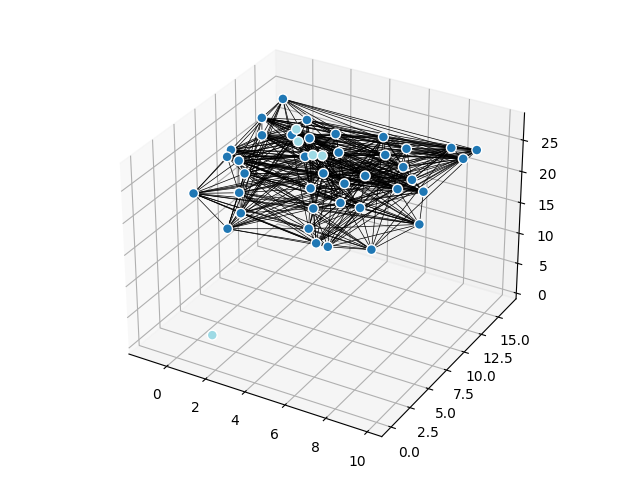

720it [00:23, 34.50it/s]

Data(x=[65], edge_index=[2, 2985], edge_attr=[2985, 104], pos=[65, 3], cell=[1, 3, 3], cell_offsets=[2985, 3], neighbors=[1], distance_vec=[2985, 3], energy_skip_co=[0], tags=[65], force=[65, 3])
tensor(1)
Graph with 41 nodes and 476 edges
{0: [0.9702693819999695, 13.689031600952148, 23.38773536682129], 1: [1.940538763999939, 2.737806558609009, 18.346067428588867], 2: [2.9108080863952637, 8.213418960571289, 20.02662467956543], 3: [3.881077527999878, 13.689031600952148, 21.70718002319336], 4: [4.851346969604492, 2.737806558609009, 16.665512084960938], 5: [5.821616172790527, 8.213418960571289, 18.346067428588867], 6: [6.791885852813721, 13.689031600952148, 20.02662467956543], 7: [7.762155055999756, 2.737806558609009, 14.984956741333008], 8: [0.0, 8.213418960571289, 21.70718002319336], 9: [0.0, 0.0, 21.70718002319336], 10: [0.9702693819999695, 5.475612640380859, 20.02662467956543], 11: [1.940538763999939, 10.951225280761719, 21.70718002319336], 12: [2.9108080863952637, 0.0, 20.02662467956

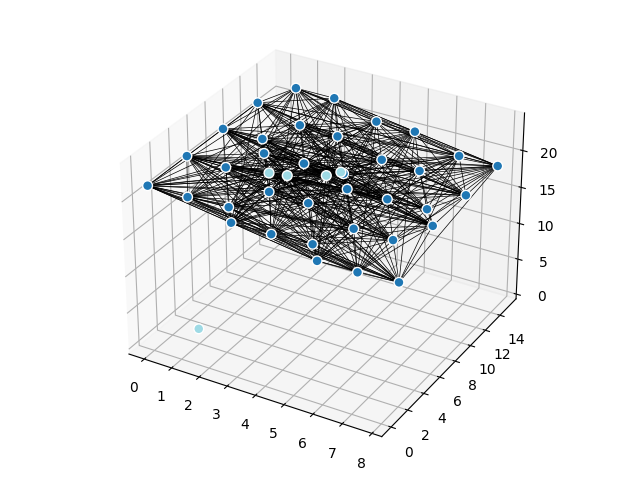

724it [00:24, 10.06it/s]

Data(x=[65], edge_index=[2, 2985], edge_attr=[2985, 104], pos=[65, 3], cell=[1, 3, 3], cell_offsets=[2985, 3], neighbors=[1], distance_vec=[2985, 3], energy_skip_co=[0], tags=[65], force=[65, 3])
tensor(1)
Graph with 11 nodes and 45 edges
{0: [6.864500045776367, 2.723113775253296, 32.09235382080078], 1: [3.731938123703003, 0.543844997882843, 32.42496109008789], 2: [10.154455184936523, 4.844296932220459, 32.62313461303711], 3: [3.7818069458007812, 6.909073829650879, 31.457454681396484], 4: [0.6529837846755981, 1.5630651712417603, 32.25081253051758], 5: [6.93154239654541, 5.945313930511475, 31.6898250579834], 6: [9.405649185180664, 7.679525375366211, 30.740272521972656], 7: [6.683775424957275, 7.636531352996826, 24.941843032836914], 8: [8.419865608215332, 5.5037689208984375, 33.23849105834961], 9: [8.706775665283203, 6.495182037353516, 32.36981964111328], 10: [8.7146635055542, 7.464629173278809, 32.68685531616211]}


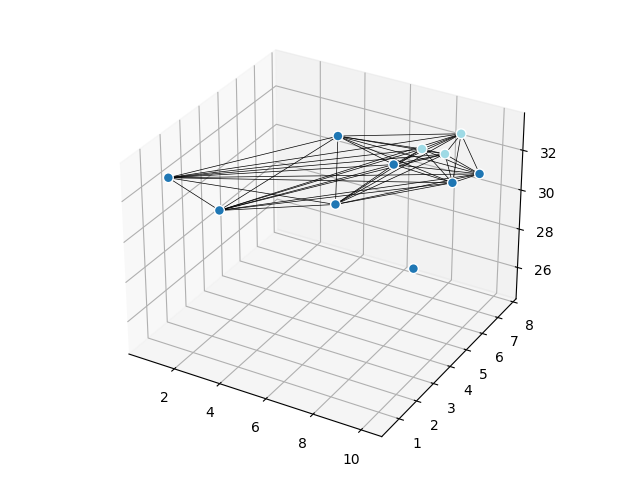

896it [00:29, 32.67it/s]

Data(x=[65], edge_index=[2, 2985], edge_attr=[2985, 104], pos=[65, 3], cell=[1, 3, 3], cell_offsets=[2985, 3], neighbors=[1], distance_vec=[2985, 3], energy_skip_co=[0], tags=[65], force=[65, 3])
tensor(1)
Graph with 20 nodes and 170 edges
{0: [1.4767792224884033, 7.766360282897949, 15.9044828414917], 1: [5.2190470695495605, 8.402669906616211, 15.67858600616455], 2: [-1.397747278213501, 4.939687252044678, 17.46847915649414], 3: [4.223428726196289, 4.303377628326416, 16.629167556762695], 4: [3.055588960647583, 0.3208180367946625, 17.63599967956543], 5: [-1.3752952814102173, 7.398964881896973, 16.113561630249023], 6: [0.5026416182518005, 2.780658006668091, 16.574243545532227], 7: [7.658198356628418, 1.105082631111145, 15.23399829864502], 8: [1.4543272256851196, 5.307082653045654, 17.2593994140625], 9: [3.0615267753601074, 9.558095932006836, 16.28689193725586], 10: [0.6048277020454407, 0.803002119064331, 18.066234588623047], 11: [3.329500436782837, 6.205573558807373, 15.2035493850708], 12

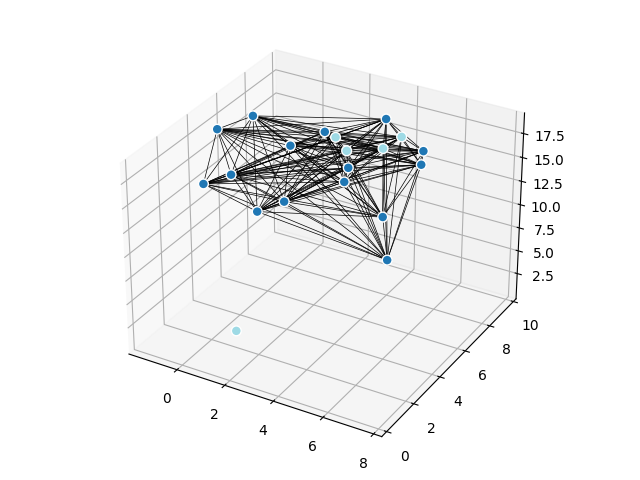

989it [00:33, 32.53it/s]

Data(x=[65], edge_index=[2, 2985], edge_attr=[2985, 104], pos=[65, 3], cell=[1, 3, 3], cell_offsets=[2985, 3], neighbors=[1], distance_vec=[2985, 3], energy_skip_co=[0], tags=[65], force=[65, 3])
tensor(1)
Graph with 23 nodes and 173 edges
{0: [0.0, 6.905669689178467, 21.485401153564453], 1: [0.0, 1.8321164846420288, 19.89093780517578], 2: [1.880267858505249, 10.006174087524414, 20.488861083984375], 3: [3.760535717010498, 6.905669689178467, 21.485401153564453], 4: [3.760535717010498, 1.8321164846420288, 19.89093780517578], 5: [5.640803337097168, 10.006174087524414, 20.488861083984375], 6: [7.521071434020996, 6.905669689178467, 21.485401153564453], 7: [7.521071434020996, 1.8321164846420288, 19.89093780517578], 8: [9.401339530944824, 10.006174087524414, 20.488861083984375], 9: [1.880267858505249, 7.46939754486084, 19.69162940979004], 10: [1.880267858505249, 1.268388271331787, 21.684709548950195], 11: [0.0, 4.368893146514893, 20.688169479370117], 12: [5.640803337097168, 7.46939754486084, 

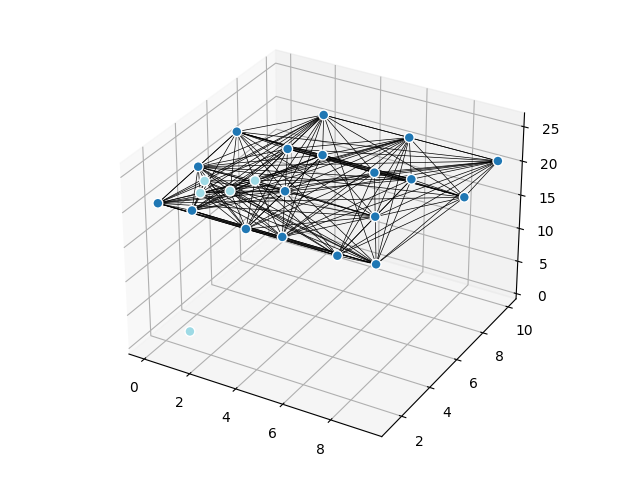

1001it [00:33, 29.73it/s]


no tag 0 Number of non-connected graphs: 8
no tag 0 Average diameter: 2.209255533199195


In [16]:
from tqdm import tqdm
# Diameter of the graph

non_connected_graphs_faenet = []
diameters_faenet = []
# Averaged over 1000 graphs
for i, x in tqdm(enumerate(loader_faenet_without_tag0)) :
    processed_x = process_datapoint(x[0], trainer)
    data_graph = oc20_to_graph(processed_x)
    if not(nx.is_connected(data_graph)):
        base_trainer_faenet_without_tag0.model_forward(x)
        non_connected_graphs_faenet.append(i)
        print(x_processed)
        pairwise_distances = torch.cdist(processed_x.pos, processed_x.pos)
        pairwise_distances[pairwise_distances == 0] = np.inf
        # print((torch.any(pairwise_distances < 0.00001, dim=1) == False).sum())
        print((torch.any(pairwise_distances < base_trainer_faenet_without_tag0.model.module.cutoff, dim=1) == False).sum())
        plot_element_3d(data_graph)
    else:
        diameters_faenet.append(nx.diameter(data_graph))
    if i > 1000:
        break

print(f"no tag 0 Number of non-connected graphs: {len(non_connected_graphs_faenet)}")
print(f"no tag 0 Average diameter: {np.mean(diameters_faenet)}")

# non_connected_graphs = []
# diameters = []
# # Averaged over 1000 graphs
# for i, x in tqdm(enumerate(loader_faenet_with_tag0)) :
#     processed_x = process_datapoint(x[0])
#     data_graph = oc20_to_graph(processed_x)
#     if not(nx.is_connected(data_graph)):
#         non_connected_graphs.append(i)
#     else:
#         diameters.append(nx.diameter(data_graph))
#     if i > 1000:
#         break

# print(f"Number of non-connected graphs: {len(non_connected_graphs)}")
# print(f"Average diameter: {np.mean(diameters)}")